# <div style="text-align: center"><p style="font-family: Arial Wide; font-size:30pt; font-style:bold">LISA Data Analysis on Dynamical Disturbances due to Micrometeoroid Impacts </p></div>

## <div style="text-align: left"><p style="font-family: Arial Wide; font-size:20pt; font-style:bold">1. Import libraries and modules </p></div>

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import lisaorbits
import h5py
import matplotlib.pyplot as plt 
from IPython.display import HTML, Image
from scipy.stats import poisson

import IPython
import matplotlib
import h5py
import numpy as np
import numpy
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import pytdi.michelson
from pytdi import Data
import psd
import os
from datetime import datetime
import lisaorbits
import scipy

## <div style="text-align: left"><p style="font-family: Arial Wide; font-size:20pt; font-style:bold">2. Define all functions </p></div>

In [2]:
def polar2cart(r, theta, phi):
    return [
         r * np.sin(theta) * np.cos(phi),
         r * np.sin(theta) * np.sin(phi),
         r * np.cos(theta)
    ]

In [3]:
def GrunModel(m):
    C     = np.array([2.2e3, 15, 1.3e-9, 1e11, 1e27, 1.3e-16, 1e6])
    g     = np.array([0.306, -4.38, 2, 4, -0.36, 2, -0.85])

    G = ((C[0]*(m**g[0])) + C[1])**g[1] + \
           C[2]*(m + C[3]*(m**g[2]) + C[4]*(m**g[3]))**g[4] + \
           C[5]*(m + C[6]*(m**g[5]))**g[6]
    
    return G

## <div style="text-align: left"><p style="font-family: Arial Wide; font-size:20pt; font-style:bold">3. Generate LISA Orbit Data </p></div>

### <div style="text-align: left"><p style="font-family: Arial Wide; font-size:16pt; font-style:bold">A. Utilizing LISA Orbits, create an _.h5_ file that describes the position, velocity, and acceleration states of the LISA constellation with desired specifications </p></div>

In [4]:
# Duration of simulation [s]
dur = 31536000

# Number of elements (instances)
size = 1000 

# Initialization of time vector
t_vec = np.linspace(0, dur, size) 

# Approximate start of LISA mission
# time_origin = datetime.datetime(2034, 1, 1, 0, 0) 

# Initialize LISA Orbits object w/ specified parameters
orbits = lisaorbits.KeplerianOrbits(size = size, dt = int(dur/size))

# Initialize filename
file = "LISA_KEPLER_ORBIT_1YR_SIZE1e3.h5"

# Write the orbits file 
#orbits.write(file)

### <div style="text-align: left"><p style="font-family: Arial Wide; font-size:16pt; font-style:bold">B. Extract the position and velocity states of the LISA constellation from the generated _.h5_ file </p></div>

In [5]:
# Initialize list containing number of spacecraft
sc_vec = ['1', '2', '3']

# Initialize list containing spacecraft DOFs
dims   = ['x', 'y', 'z']

# Initilize vector containing the callback states
dyn    = ['x', 'v', 'a']

# Construct dictionary to extracted values
dynamics = {}                

# simple for loop to place sc dynamics vectors into dictionary
for i, dyn in enumerate(dyn):
    for j, scvec in enumerate(sc_vec):
        for k, dim in enumerate(dims):
            with h5py.File(f'./{file}', 'r') as f:
                # barycentric coordinate time
                # convert from distance units from km to m
                dynamics[f'{scvec}_{dim}_{dyn}'] = f[f'/tcb/{dyn}'][:, j, k]/1000 

## <div style="text-align: left"><p style="font-family: Arial Wide; font-size:20pt; font-style:bold">4. Generate Flux Probability Model Utilizing NASA MEM Model </p></div>

### <div style="text-align: left"><p style="font-family: Arial Wide; font-size:16pt; font-style:bold">A. Generate momentum-dependent flux values </p></div>

'Add more description here'

$$
\begin{align*}
F_{raw} &= \frac{F}{d\Omega dv}\\
F_{raw} &= \frac{F}{cos(\phi_i)d\phi d\theta dv}\\
F_{raw} &= \frac{2F}{cos(\phi_i) \left(\phi_{i+1} - \phi_{i-1} \right) \left(\theta_{i+1} - \theta_{i-1} \right)}\\
F &= \frac{F_{raw} \left[cos(\phi_i) \left(\phi_{i+1} - \phi_{i-1} \right) \left(\theta_{i+1} - \theta_{i-1} \right)\right]}{2}
\end{align*}
$$

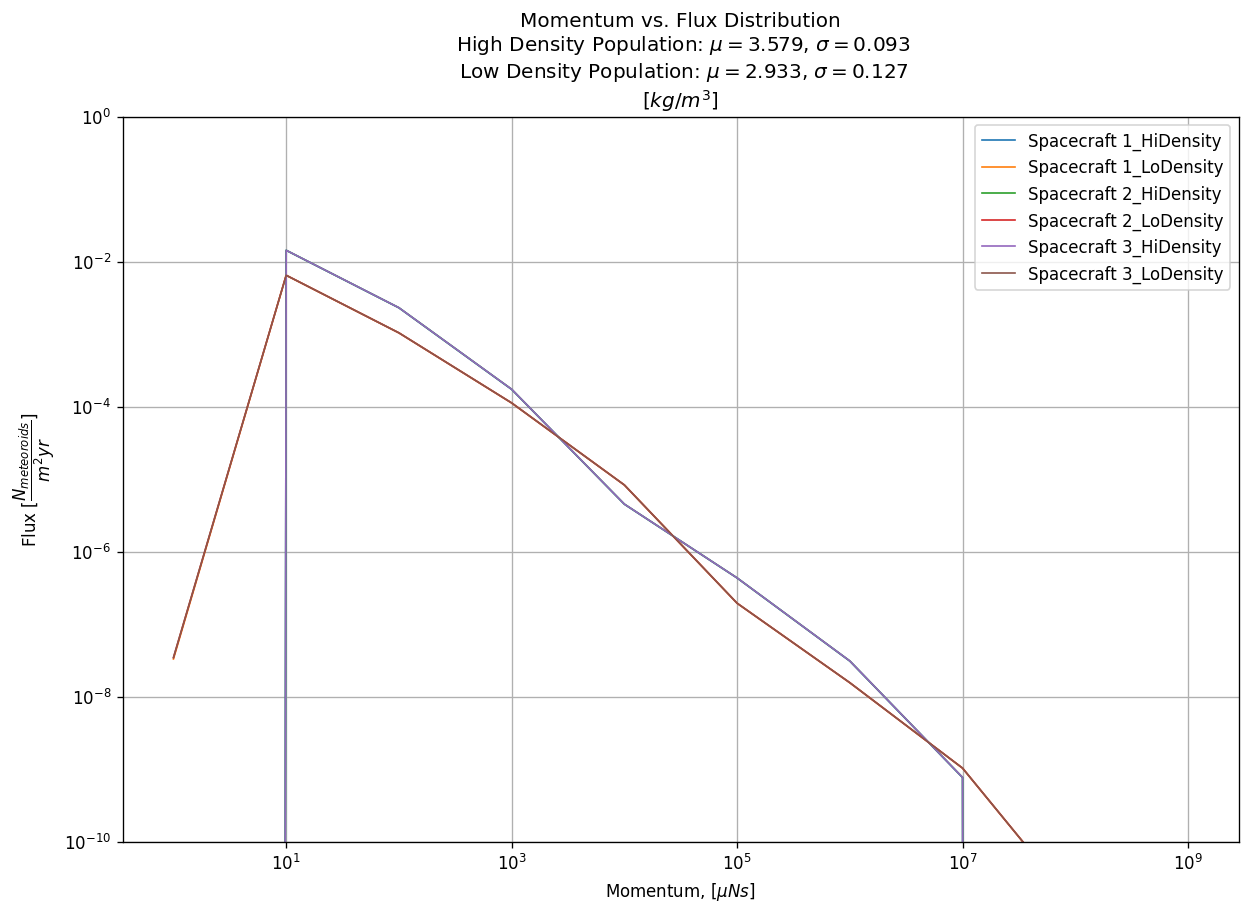

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8), dpi = 120, facecolor='w')

files               = ['LISA_sc1_04_18_2023', 'LISA_sc2_04_30_2023', 'LISA_sc3_04_30_2023']
densities           = ['HiDensity','LoDensity']
spacecraft_names    = ['Spacecraft 1','Spacecraft 2','Spacecraft 3']
density_mean_values = ['3.579','2.933']
density_std_values  = ['0.093','0.127']

numflux = 1652
numv = 80

momdictionary = {}
mommapdictionary = {}

for nindex, name in enumerate(files):
    for dindex, density in enumerate(densities):
        
        ##### PREPROCESSING #####

        # We first need to make sure we are returning the correct velocity bin values
        # Note, when we call cast the raw data to a pandas dataframe, the column names are offset by one element, so
        # we take caution in initializing the values that correspond to the flux values.
        velocity_bins = pd.concat([pd.Series(['THETAavg']), pd.Series(np.linspace(0.5, 78.5, 79))], ignore_index=True) 

        # Here we simply just read the table using pandas
        iglooavg = pd.read_table(f"/home/lisauser/workspace/MEM3_Windows_301/MEM3_Windows/{name}/{density}/igloo_avg.txt",sep="\s+", header = 7)

        # We take the matrix of flux values dependent on velocity and cast it to a numpy array with appropriate dimensions for processing
        Fd = np.array([iglooavg[str(velocity_bins[i])] for i in range(numv)]).T

        # Since each raw flux value is per solid angle interval, we need dPhi and dTheta to correct for that interval
        dPhi   = (iglooavg['PHI1'] - iglooavg['J']) * (np.pi/180);
        dTheta = (iglooavg['THETA1'] - iglooavg['PHI2']) * (np.pi/180);

        # Construct preprocessed flux matrix using a vectorized for loop
        Flux = np.array([[.5 * Fd[i, j] * np.cos(iglooavg['THETA2'].to_numpy()[i] * (np.pi/180)) * dPhi[i] * dTheta[i] for j in range(numv)] for i in range(numflux)])

        ##### GRUN MODEL PROCESS #####
        # Constants
        numbins = 10
        vbins = np.linspace(0.5, 79.5, numv)
        momentumbins = np.logspace(-6, 3, numbins)
        mass = np.logspace(-6, 1, numbins)

        # Computing Grun Model flux 
        # Output: Flux_Grun(mass)
        G = GrunModel(mass) * (365.25 * 24 * 3600)
        dgrun = np.array([G[k] - G[k+1] for k in range(numbins - 1)])
        dgrun /= np.sum(dgrun)
        
        # Construct Momentum Matrix w/ MEM velocity bins and mass array
        momentum_mat = vbins.reshape(-1,1)@mass.reshape(1,-1)
        
        # Expanding flux array with an extra dimension: m (mass)
        # Output: F(phi, theta, velocity, mass)
        fluxM = np.array([[[Flux[ii, jj] * dgrun[kk] for kk in range(numbins-1)] for jj in range(numv)] for ii in range(numflux)])
        
        # Bin the expanded flux values into respective momentum bins
        # Output: F_total_1d(momentum)
        F_total_1d = np.zeros(numbins)
        for l in range(numbins - 1):
            for i in range(numflux):
                for j in range(numv):
                    for k in range(numbins - 1):
                        if l == 0:
                                if (momentum_mat[j, k] <= momentumbins[l]):
                                    F_total_1d[l]     += fluxM[i, j, k]   
                        elif l == (numbins - 1):
                                if (momentumbins[l] <= momentum_mat[j, k]):
                                    F_total_1d[l]     += fluxM[i, j, k]    
                        else: 
                            if (momentumbins[l] <= momentum_mat[j, k] < momentumbins[l + 1]):
                                    F_total_1d[l]     += fluxM[i, j, k] 

        # Bin the expanded flux values into respective momentum and sky position bins
        # Output: F_total_2d(sky position, momentum)          
        F_total_2d = np.zeros([numflux, numbins])
        for l in range(numbins - 1):
            for i in range(numflux):
                for j in range(numv):
                    for k in range(numbins - 1):
                        if l == 0:
                                if (momentum_mat[j, k] <= momentumbins[l]):
                                    F_total_2d[i, l]     += fluxM[i, j, k]   
                        elif l == (numbins - 1):
                                if (momentumbins[l] <= momentum_mat[j, k]):
                                    F_total_2d[i, l]     += fluxM[i, j, k]
                        else: 
                            if (momentumbins[l] <= momentum_mat[j, k] < momentumbins[l + 1]):
                                    F_total_2d[i, l]     += fluxM[i, j, k]
        

        ##### PLOTS #####
        # Plot microNewtons against momentum dependent flux values
        ax.loglog(momentumbins * 1e6, F_total_1d, linewidth = 1, label=f'{spacecraft_names[nindex]}_{density}')
        #plt.xlim([1e1, 1e7])
        plt.ylim([1e-10, 1e0])
        plt.title(f'Momentum vs. Flux Distribution\n High Density Population: $\mu = {density_mean_values[0]}$, $\sigma = {density_std_values[0]}$\n Low Density Population: $\mu = {density_mean_values[1]}$, $\sigma = {density_std_values[1]}$\n[$kg/m^3$]')
        plt.ylabel(r'Flux [$\dfrac{N_{meteoroids}}{m^2 yr}$]')
        plt.xlabel(r'Momentum, $[\mu N s]$') # newton seconds  
        plt.grid(True)
        plt.legend()
        #plt.savefig('momentum distribution.png',dpi=200)
        
        # Store data into respective dictionaries
        momdictionary[f'{spacecraft_names[nindex]}_{density}'] = F_total_1d
        mommapdictionary[f'{spacecraft_names[nindex]}_{density}'] = F_total_2d

plt.show()

## <div style="text-align: left"><p style="font-family: Arial Wide; font-size:20pt; font-style:bold">5. Determine direction of impact, location of impact, and momentum transferred for each segmented partition of the spacecraft geometry </p></div>


### <div style="text-align: left"><p style="font-family: Arial Wide; font-size:16pt; font-style:bold">A. Generate momentum-dependent flux values </p></div>

- Need to ensure units are correct
- Need to implement conditions to check whether the impact direction is hitting the segmented partition or not

In [9]:
# Initialize dictionary object
dictionary = {}
data_rows = []

# Insert each spacecraft's flux map distribution (momentum-dependent flux values) into the initiliazed dictionary
for i in range(3):
    dictionary[f'sc_pop_{i+1}'] = mommapdictionary[f'Spacecraft {i+1}_LoDensity'] + mommapdictionary[f'Spacecraft {i+1}_HiDensity']

# Mass of the spacecraft in [kg], extracted from 'config_dynamics.py' 
m_SC = 1415

# Inertial (or Mass) matrix of the spacecraft [kg]
I_SC_CoM_B = (np.array([np.array([2099.6,    -0.62,     9.9]) ,\
                       np.array([  -0.62,  2135.5,    -0.33]) , \
                       np.array([   9.9,     -0.33, 1843.5])]))

# Surface area of a cylinder [m]
radius = 2
h = 3
A_orig = 2 * np.pi * radius * h + 2 * np.pi * radius**2

# Total number of desired partitions for all parts
N = 16

# Number of desired radii
M = 4 

# Create an array of the angular positions that correspond to the top and bottom faces of the cylinder
angpos_topbot = np.linspace(0, 180, int(N/M)+1) 

# Create an array of the angular positions that correspond to the side face of the cylinder
angpos_side   = np.linspace(0, 180, N+1)

# Create an array that contains the radius positions that correspond to the top/bottom faces of the cylinder
radii = np.linspace(0, radius, M+1) 

# Initialize the numpy arrays that we will use to iterate through the angular position indices
Atopbot = np.zeros([3, 2, len(angpos_topbot)-1, len(radii)-1])
Aside   = np.zeros([3, len(angpos_side)-1])  

# Initialize the number of events
numevents = 0    

# Initialize the number of years we will simulate (remember, our flux is [#ofparticles/m^2*yr])
years = 100

# Iterate through each spacecraft 
for ll in range(3):
    ### Corresponds to top/bottom faces of cylinder ###
    # Iterate through top and bottom face 
    for kk in range(2):
        # Iterate through angular positions (same for both top/bottom faces)
        for ii in range(len(angpos_topbot)-1):
            # Iterate through the radius positions (only corresponds to top/bottom face)
            for jj in range(M):
                # Use the sky map for the corresponding spacecraft to generate a poisson random distribution
                # that returns whether an impact event has occured in a certain sky position
                rand_ind   = poisson.rvs(dictionary[f'sc_pop_{ll+1}'] * years)

                # Return the index position of that randomly picked event that
                # corresponds to a location in the sky map and an attached momentum value
                loc_ind    = np.where(rand_ind!=0)

                # How many of these events occured? (Typically this value will be 1 because of how low the probabilities
                # we get in the simulation)
                num        = len(loc_ind[0])

                # For the corresponding indices, return the area for that segment on the spacecraft
                Atopbot[ll, kk, ii, jj] = M/N * np.pi * (radii[jj+1]**2 - radii[jj]**2)

                # Iterate through the number of events that occured
                for nn in range(num):
                    # Record the impact direction (unit vector) for each particle
                    dictionary[f'Impact_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = np.array(polar2cart(-1, \
                        iglooavg['THETA2'].values[loc_ind[0][nn]], \
                        iglooavg['PHIavg'].values[loc_ind[0][nn]]))
                    
                    # Record the momenutm value
                    dictionary[f'Momentum_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = momentumbins[loc_ind[1][nn]]

                    # Record the area of that segment
                    dictionary[f'Area_{jj}_{ii}_{kk}_{ll}_{nn}_tb']     = Atopbot[ll, kk, ii, jj]

                    # Record the angular position of where that segment is located 
                    dictionary[f'Angle_{jj}_{ii}_{kk}_{ll}_{nn}_tb']    = angpos_topbot[ii] - angpos_topbot[1]/2

                    # Record how far or the radius position from the center of where this segment lies
                    dictionary[f'Radius_{jj}_{ii}_{kk}_{ll}_{nn}_tb']   = radii[jj]

                    # Calculate the x,y,z components for the vector which
                    # originates from the center of the geometry to the center of the 
                    # segment
                    center_x = dictionary[f'Radius_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] * \
                        np.cos((np.pi/180)*dictionary[f'Angle_{jj}_{ii}_{kk}_{ll}_{nn}_tb'])
                    center_y = dictionary[f'Radius_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] * \
                        np.sin((np.pi/180)*dictionary[f'Angle_{jj}_{ii}_{kk}_{ll}_{nn}_tb'])
                    # Dependent on the index, is it the top or bottom face?
                    if (kk == 0):
                        dictionary[f'Face_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = 'Top Face'
                        center_z = h/2
                    else:
                        dictionary[f'Face_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = 'Bottom Face'  
                        center_z = -h/2

                    # Record the vector from the COM of the spacecraft to center of segment
                    dictionary[f'Center_vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = np.array([center_x, center_y, center_z])

                    # Calculate the change in translational velocity using the change in momentum attached with the unit vector
                    # impact direction divided by the mass of the spacecraft, then record the vector 
                    dictionary[f'DeltaV_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = (dictionary[f'Momentum_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] * dictionary[f'Impact_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb']) / m_SC

                    # Calulate the change in angular velocity by performing the cross product between the center vector and change in velocity vector and then
                    # left matrix multiply the inverse of the spacecraft's mass matrix, then record the vector
                    dictionary[f'DeltaW_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] = np.linalg.inv(I_SC_CoM_B)@(np.cross(dictionary[f'Center_vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb'], \
                        dictionary[f'Momentum_{jj}_{ii}_{kk}_{ll}_{nn}_tb'] * dictionary[f'Impact_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb']))

                    # For each iteration, the number of events will go up by one
                    numevents += 1

                    nrow = {
                        'Face': dictionary[f'Face_{jj}_{ii}_{kk}_{ll}_{nn}_tb'],
                        'Radial_Position': radii[jj],
                        'Angular_Position': (angpos_topbot[ii] - angpos_topbot[1]/2),
                        'Area': Atopbot[ll, kk, ii, jj],
                        'Momentum': momentumbins[loc_ind[1][nn]],
                        'dV_mag': np.linalg.norm(dictionary[f'DeltaV_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb']),
                        'dW_mag': np.linalg.norm(dictionary[f'DeltaW_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb']),
                        'dV_vector': dictionary[f'DeltaV_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb'],
                        'dW_vector': dictionary[f'DeltaW_Vector_{jj}_{ii}_{kk}_{ll}_{nn}_tb']
                    }
                    data_rows.append(nrow)

    # Iterate through the angular positions that correspond to the side face of the cylinder
    for mm in range(len(angpos_side)-1):
        # Use the sky map for the corresponding spacecraft to generate a poisson random distribution
        # that returns whether an impact event has occured in a certain sky position
        rand_ind   = poisson.rvs(dictionary[f'sc_pop_{ll+1}'] * years)

        # Return the index position of that randomly picked event that
        # corresponds to a location in the sky map and an attached momentum value
        loc_ind    = np.where(rand_ind!=0)

        # How many of these events occured? (Typically this value will be 1 because of how low the probabilities
        # we get in the simulation)
        num        = len(loc_ind[0])

        # For the corresponding indices, return the area for that segment on the spacecraft
        Aside[ll, mm] = (2/N) * np.pi * radii[-1] * h

        # Iterate through the number of events that occured
        for nn in range(num):
            # Record the impact direction (unit vector) for each particle
            dictionary[f'Impact_Vector_{mm}_{ll}_{nn}_s']  = np.array(polar2cart(-1, \
                iglooavg['THETA2'].values[loc_ind[0][nn]], \
                iglooavg['PHIavg'].values[loc_ind[0][nn]]))
            # Record the momenutm value
            dictionary[f'Momentum_{mm}_{ll}_{nn}_s'] = momentumbins[loc_ind[1][nn]]
                                
            # Record the area of that segment
            dictionary[f'Area_{mm}_{ll}_{nn}_s']     = Aside[ll, mm]

            # Record the angular position of where that segment is located 
            dictionary[f'Angle_{mm}_{ll}_{nn}_s']    = angpos_side[mm] - angpos_side[1]/2

            # Record the radius of that segment of the spacecraft (will always be the radius of the outer surface)
            dictionary[f'Radius_{mm}_{ll}_{nn}_s']   = radii[-1]

            # Record the face (always side face for this FOR loop)
            dictionary[f'Face_{mm}_{ll}_{nn}_s']     = 'Side Face'

            # Calculate the x,y,z components that form the vector from the 
            # COM of the spacecraft to the indexed segment 
            center_x = dictionary[f'Radius_{mm}_{ll}_{nn}_s'] * \
                np.cos((np.pi/180)*dictionary[f'Angle_{mm}_{ll}_{nn}_s'])
            center_y = dictionary[f'Radius_{mm}_{ll}_{nn}_s'] * \
                np.sin((np.pi/180)*dictionary[f'Angle_{mm}_{ll}_{nn}_s'])
            center_z = 0 

            # Record the vector from the COM of the spacecraft to center of segment
            dictionary[f'Center_vector_{mm}_{ll}_{nn}_s'] = np.array([center_x, center_y, center_z])    

            # Calculate the change in translational velocity using the change in momentum attached with the unit vector
            # impact direction divided by the mass of the spacecraft, then record the vector 
            dictionary[f'DeltaV_Vector_{mm}_{ll}_{nn}_s'] = (dictionary[f'Momentum_{mm}_{ll}_{nn}_s'] * dictionary[f'Impact_Vector_{mm}_{ll}_{nn}_s']) / m_SC

            # Calulate the change in angular velocity by performing the cross product between the center vector and change in velocity vector and then
            # left matrix multiply the inverse of the spacecraft's mass matrix, then record the vector
            dictionary[f'DeltaW_Vector_{mm}_{ll}_{nn}_s'] = np.linalg.inv(I_SC_CoM_B)@(np.cross(dictionary[f'Center_vector_{mm}_{ll}_{nn}_s'], \
                dictionary[f'Momentum_{mm}_{ll}_{nn}_s'] * dictionary[f'Impact_Vector_{mm}_{ll}_{nn}_s']))
            
            # For each iteration, the number of events will go up by one
            numevents += 1

            nrow = {
                    'Face': dictionary[f'Face_{mm}_{ll}_{nn}_s'],
                    'Radial_Position': radii[-1],
                    'Angular_Position': (angpos_side[mm] - angpos_side[1]/2),
                    'Area': Aside[ll, mm],
                    'Momentum': momentumbins[loc_ind[1][nn]],
                    'dV_mag': np.linalg.norm(dictionary[f'DeltaV_Vector_{mm}_{ll}_{nn}_s']),
                    'dW_mag': np.linalg.norm(dictionary[f'DeltaW_Vector_{mm}_{ll}_{nn}_s']),
                    'dV_vector': dictionary[f'DeltaV_Vector_{mm}_{ll}_{nn}_s'],
                    'dW_vector': dictionary[f'DeltaW_Vector_{mm}_{ll}_{nn}_s']
                }
            data_rows.append(nrow)

df = pd.DataFrame(data_rows)

# The sum of the top/bottom faces and side faces should equate to 
# 3 times the original formula for the surface area of the cylinder
A = np.sum(Atopbot) + np.sum(Aside)

# Diplay the values
print(f'Area after processing: {A:.3f}\nOriginal surface area of constellation: {A_orig*3:.3f}')

Area after processing: 188.496
Original surface area of constellation: 188.496


### B. Display the table of values formed by the process above 

In [24]:
df

,Face,Radial_Position,Angular_Position,Area,Momentum,dV_mag,dW_mag,dV_vector,dW_vector
0,Top Face,0.0,-22.50,0.785398,0.00001,7.067138e-09,5.372060e-10,"[-4.965724384569794e-10, -2.1011755745175314e-...","[2.1226934319076072e-10, -4.934880819300334e-1..."
1,Top Face,0.0,-22.50,0.785398,0.00001,7.067138e-09,5.385829e-10,"[-4.5960538930535964e-10, 2.8195116723658053e-...","[-2.8516811565708735e-10, -4.56890079445021e-1..."
2,Top Face,1.0,-22.50,2.356194,0.00001,7.067138e-09,4.428138e-09,"[-6.144202656095352e-09, 5.7586758808664815e-1...","[8.494048455516157e-10, -3.969493250746509e-09..."
3,Top Face,1.0,-22.50,2.356194,0.00010,7.067138e-08,4.089110e-08,"[2.8290515033094417e-08, 1.7352212008855465e-0...","[-3.3734171093936054e-08, -1.0083937375434234e..."
4,Top Face,0.0,22.50,0.785398,0.00001,7.067138e-09,5.132725e-09,"[2.13005846477583e-09, -4.623913613748402e-09,...","[4.675088054276954e-09, 2.1184450883444374e-09..."
...,...,...,...,...,...,...,...,...,...
157,Side Face,2.0,123.75,4.712389,0.00001,7.067138e-09,9.831707e-09,"[2.829051503309442e-09, 1.7352212008855466e-09...","[7.018123793405689e-09, 4.594997092028897e-09,..."
158,Side Face,2.0,123.75,4.712389,0.00001,7.067138e-09,3.090067e-09,"[-5.0592119844423355e-09, 4.727931161629405e-0...","[-1.5949238671849732e-09, -1.040125155432439e-..."
159,Side Face,2.0,123.75,4.712389,0.00010,7.067138e-08,9.326160e-08,"[2.4630913764266584e-10, -1.6735984922344397e-...","[-7.703191181849189e-08, -5.0571635796810224e-..."
160,Side Face,2.0,146.25,4.712389,0.00001,7.067138e-09,9.293869e-09,"[-3.0832513967094843e-09, -1.2280414687904909e...","[4.65465091458578e-09, 6.8770318908378774e-09,..."


This function displays the momentum, index, and number of impacts that contained unique momentum values from the simulation

In [52]:
F1 = np.unique(df['dV_mag'].round(decimals=11).values, return_index=True, return_counts=True)
F2 = np.unique(df['dW_mag'].round(decimals=11).values, return_index=True, return_counts=True)
F1[1], F2[1]

(array([2, 1, 0]),
 array([  2,   6,   5, 142,  29,   1,   4,  43,  51,  16,   0,  30, 131]))

In [25]:
N = len(df['dV_vector'].values) # number of impacts 
D = 6 # number of DOFs 
vec = np.zeros([N, 6])
for jjj in range(N):
    for iii in range(6):
        if iii >= 3: 
            vec[jjj, iii] = np.array(df['dW_vector'][:][:])[jjj][iii-3]
        else:
            vec[jjj, iii] = np.array(df['dV_vector'][:][:])[jjj][iii]

vec.shape

(162, 6)

Histograms on each exis 

## 6. Inject $\Delta v$ and $\Delta \omega$ Values into LISANode Simulator

This will move all the stuff from the LISANodeMeteoroidGlitch_2 notebook to here, from start to end, i've made all the markdown titles and carried it from that notebook. 

### A. Assign glitch parameters

The magnitudes of the glitch injections will be the results of the simulation above

In [5]:
# Define glitch signal parameters
# Initial start time
t0 = 0.0

# Duration of the glitch
t_dur = 1e3

# Sampling frequency of the file
Fs = 16.0

# Time step 
dt = 1.0/Fs

# Time of injection
t_inj = 500

# Number of elements (size of the file)
size = int(Fs*t_dur)

# Injection onto spacecraft body X-axis and Phi-axis
params    = ['sc_1_X','sc_1_Y','sc_1_Z',\
             'sc_1_Theta','sc_1_Eta','sc_1_Phi'] 

# Simulation time duration
sim_tdur = 1e3

### B. Create input glitch files

In [17]:
os.chdir('/home/lisauser/notebooks/')
!pwd

/home/lisauser/notebooks


In [27]:
# Iterate through all the impacts
for impact_num in range(N): 
    with h5py.File(f"inputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5","w") as f:
        # Initialize the time vector and write time vector into input glitch file
        t = np.arange(0, t_dur, dt)
        f.create_dataset("t", data=t)  
        # Additional parameters necessary for passing the PyTDI and LISANode simulator
        f.attrs["fs"]   = Fs
        f.attrs["t0"]   = t0
        f.attrs["size"] = size
        # Iterate through each spacecraft body degree of freedom
        for i, param in enumerate(params):
            # Create the step function in the iterated DOF with the preimposed momentum values
            step = np.zeros_like(t)
            step[t>=t_inj] = vec[impact_num, i] * 1e3 # magnify the impact
            f.create_dataset(f'{param}', data=step)


In [28]:
with h5py.File(f"inputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num}.h5","r") as f:
    print(f.keys())

<KeysViewHDF5 ['sc_1_Eta', 'sc_1_Phi', 'sc_1_Theta', 'sc_1_X', 'sc_1_Y', 'sc_1_Z', 't']>


In [29]:
glitch_file = []; output_file = [];
# Iterate through all the impacts
for impact_num in range(N): 
    glitch_file.append(f"inputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5")
    output_file.append(f"outputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5")

In [30]:
orbit_file = f"kepler-orbits-{sim_tdur*Fs}.h5"

In [23]:
# Generate standard LISANode simulation
!lisanode run --build lisanode.lisa:LISA -d {sim_tdur} --orbit-path=orbit_file 

Analyzing 'LISA'...
Saving cpp file to './LISA.cpp'...
Building simulation to './LISA'...


In [31]:
# Generate standard LISANode simulation
# need to enumerate impacts not glitch files
for i, name in enumerate(glitch_file):
    !./LISA --duration={sim_tdur} --orbit-path={orbit_file} --glitch-file={name} --output={output_file[i]}

Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
Using orbit file version 2.0
HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 139927790466880:
  #000: ../../../src/H5D.c line 298 in H5Dopen2(): unable to open dataset
    major: Dataset
    minor: Can't open object
  #001: ../../../src/H5Dint.c line 1410 in H5D__open_name(): not found
    major: Dataset
    minor: Object not found
  #002: ../../../src/H5Gloc.c line 422 in H5G_loc_find(): can't find object
    major: Symbol table
    minor: Object not found
  #003: ../../../src/H5Gtraverse.c line 851 in H5G_traverse(): internal path traversal failed
    major: Symbol table
    minor: Object not found
  #004: ../../../src/H5Gtraverse.c line 627 in H5G__traverse_real(): traversal operator failed
    major: Symbol table
    minor: Callback failed
  #005: ../.

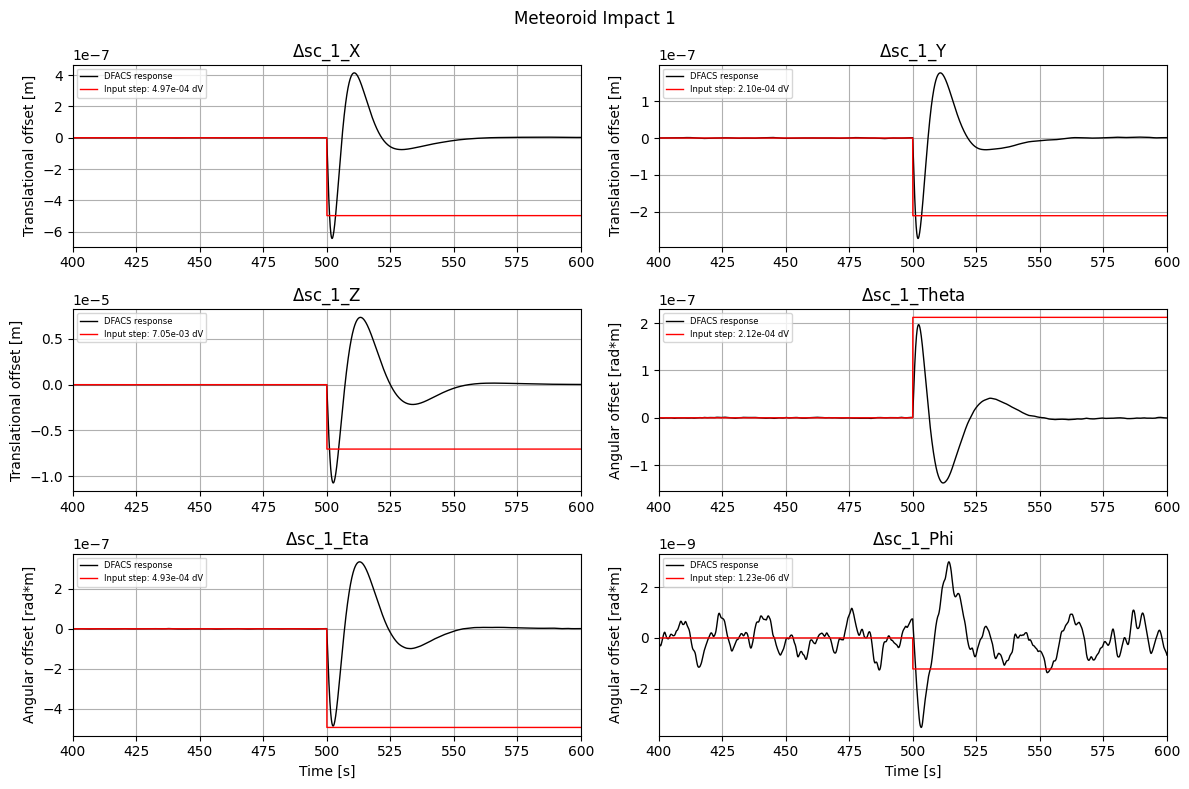

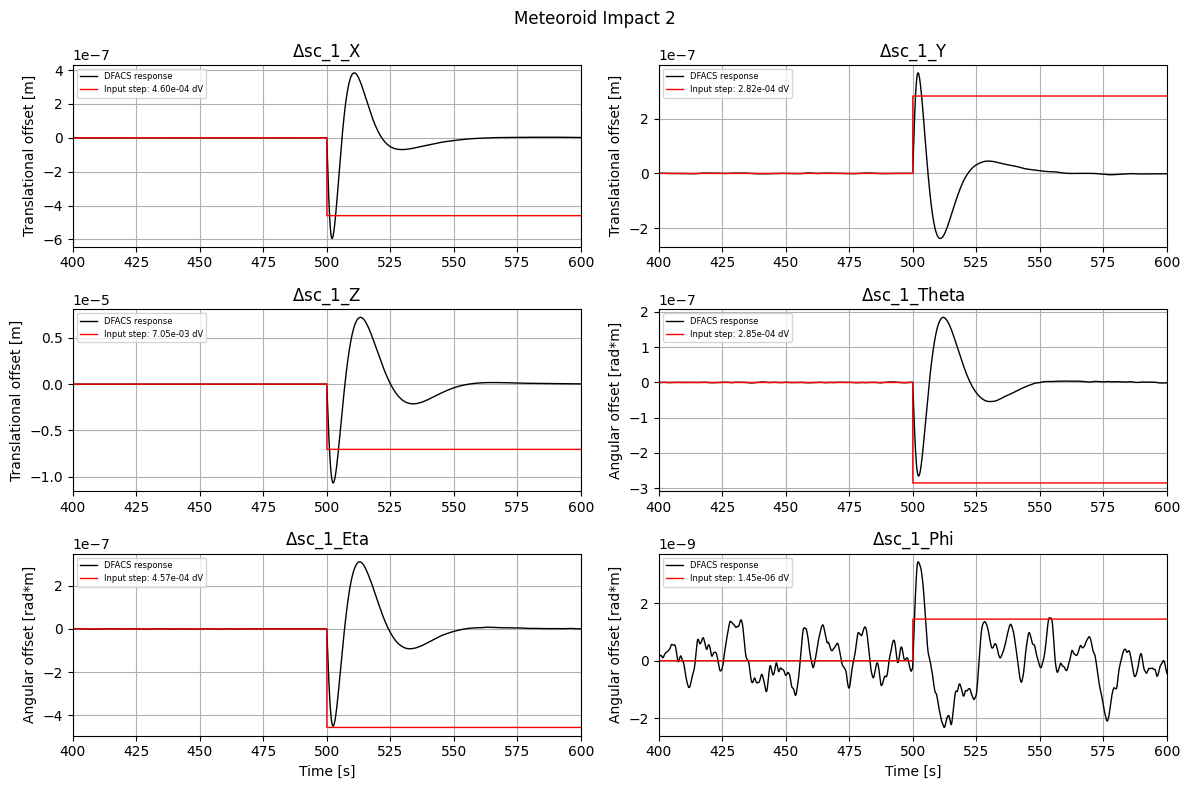

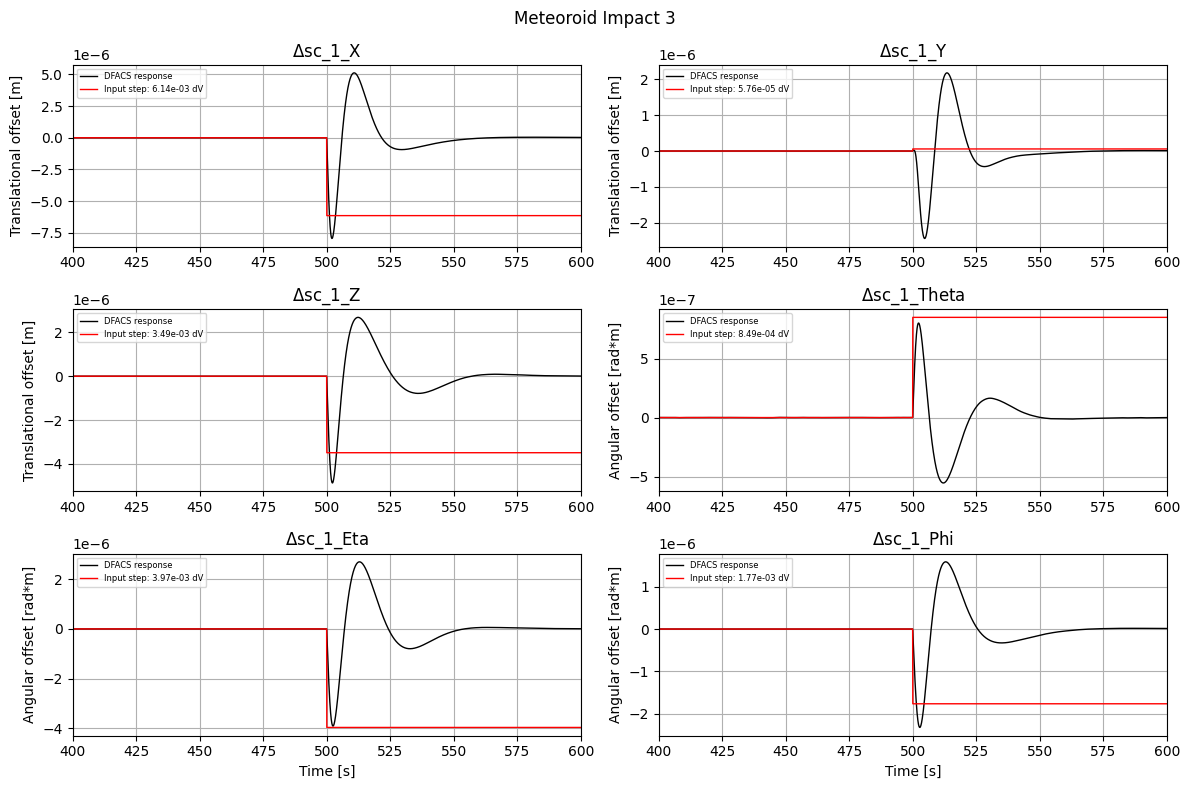

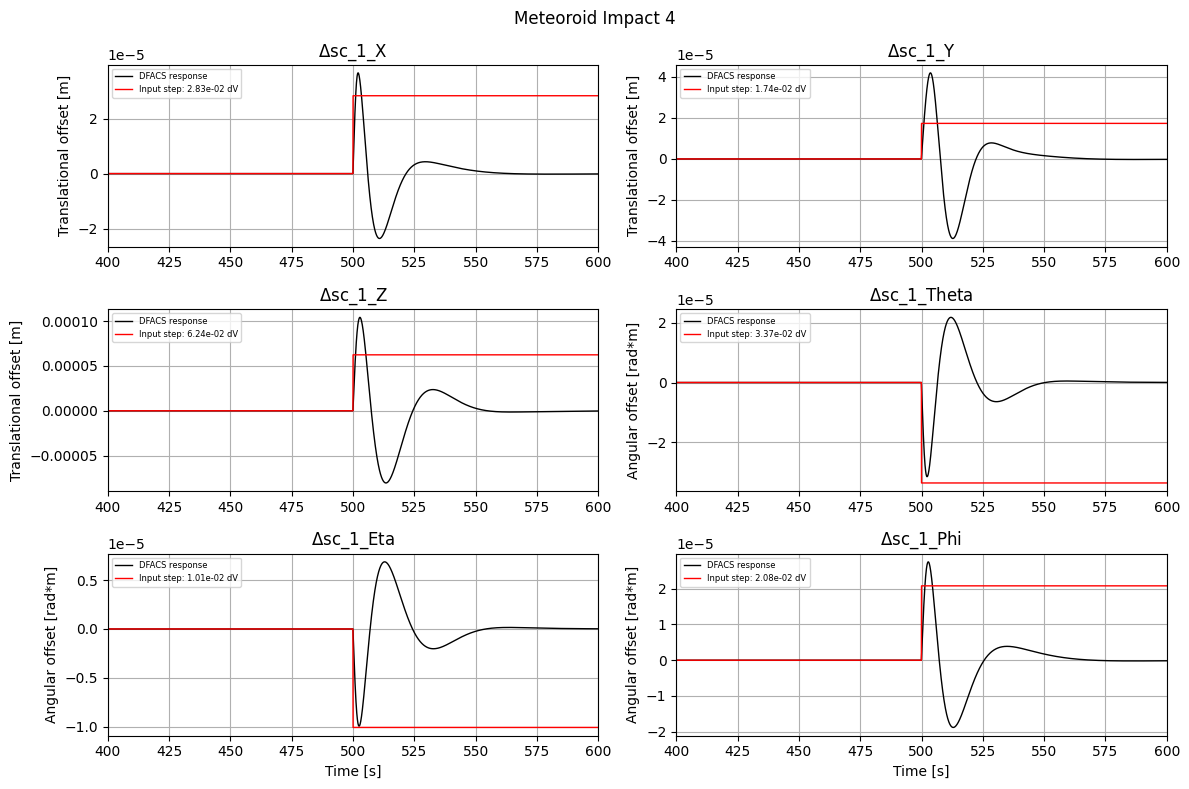

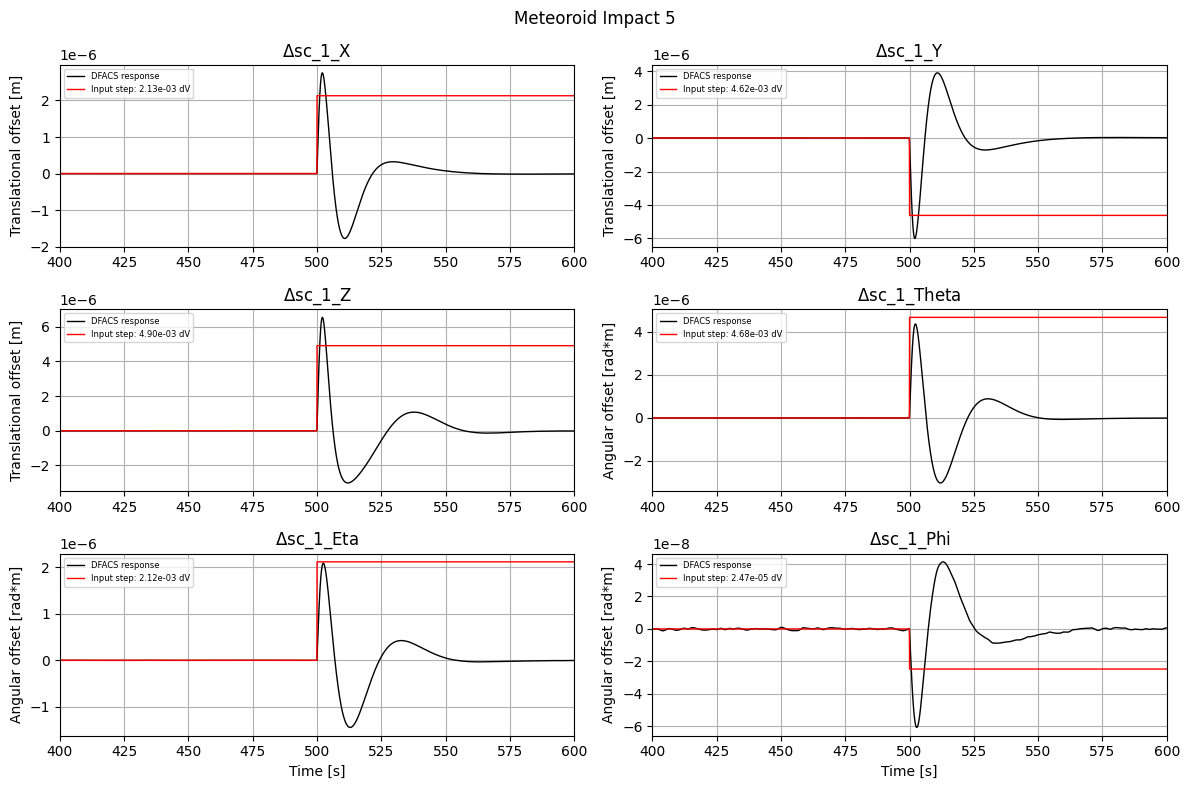

In [52]:
%matplotlib inline
 
colors = ['black','red']
os.chdir('/home/lisauser/notebooks/')
for impact_num in range(5): 
    fig = plt.figure(figsize=(12,8),dpi=100,facecolor=(1,1,1))
    plt.suptitle(f'Meteoroid Impact {impact_num+1}');
    plt.tight_layout()
    for i, param in enumerate(params):
        with h5py.File(f"outputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5","r") as f:
            y1 = f[param][:]
            t1 = np.arange(0, sim_tdur, 1/Fs)
        with h5py.File(f"inputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5","r") as f:
            y2 = f[param][:]
            t2 = f['t'][:]
            h = np.abs(f[param][:][np.argmax(np.abs(f[param][:]))])

            # Create axis object for each parameter 
            ax = plt.subplot(int(len(params)/2),2,i+1)
            
            ax.plot(t1, y1, color=colors[0], ls="-", label=f'DFACS response', linewidth=1)
            ax.plot(t2, y2, color=colors[1], ls="-", label=f'Input step: {h * 1e3:.2e} dV', linewidth=1)

            plt.grid()
            plt.legend(loc=2, prop={'size': 6})
            plt.title(rf'$\Delta${param}')
            plt.tight_layout()

            # Set x-axis limit to time vector minimum and maximum values
            ax.set_xlim([400, 600])
            if i == 0 or i == 1 or i == 2:
                ax.set_ylabel('Translational offset [m]')
            else:
                ax.set_ylabel('Angular offset [rad*m]')

            if i == 4 or i == 5:
                ax.set_xlabel('Time [s]')
            

In [161]:
np.save('10_09_2023_Meteoroid_Sim_Vec',vec)

In [62]:
momenta

[1.7380034466748042,
 2.05122469519146,
 2503.405663774644,
 29423.891822991915,
 34.98875132863373,
 490.8999784581218,
 4538.296353700331,
 25.085824067634505,
 21.081647336497515,
 6655.36454459502,
 3455.2631919171235,
 358353.343142151,
 1528.201801027313,
 17.458187109465175,
 45.809119672845554,
 41.13726516204727,
 446.3967338314737,
 4484.27557028686,
 6261.190131912014,
 33311.48058359791,
 37.959185335102774,
 47.211176710473666,
 3.966230390559653,
 6300.524181691396,
 422.4683438486416,
 243.35239601902052,
 578.2464514608823,
 17.903640183183928,
 37.14440832963384,
 3090.5436571256478,
 584.9099836942136,
 14333.824250818305,
 5343.97824307039,
 2695.017450256511,
 3344.8605364324153,
 4143.058657981642,
 11977.788471454538,
 7202.8205057949435,
 12560.402303821786,
 12069.012390732394,
 7593.2771219792,
 13348.637450914493,
 7522.944784447663,
 215.85637674812443,
 1328.438688656968,
 629.1837667065156,
 5485.606696059632,
 80794.88025488873,
 3398.3425810234526,
 4236.

In [35]:
np.arange(-1e-3,1e-3,1e-4)

array([-1.00000000e-03, -9.00000000e-04, -8.00000000e-04, -7.00000000e-04,
       -6.00000000e-04, -5.00000000e-04, -4.00000000e-04, -3.00000000e-04,
       -2.00000000e-04, -1.00000000e-04,  4.33680869e-19,  1.00000000e-04,
        2.00000000e-04,  3.00000000e-04,  4.00000000e-04,  5.00000000e-04,
        6.00000000e-04,  7.00000000e-04,  8.00000000e-04,  9.00000000e-04])

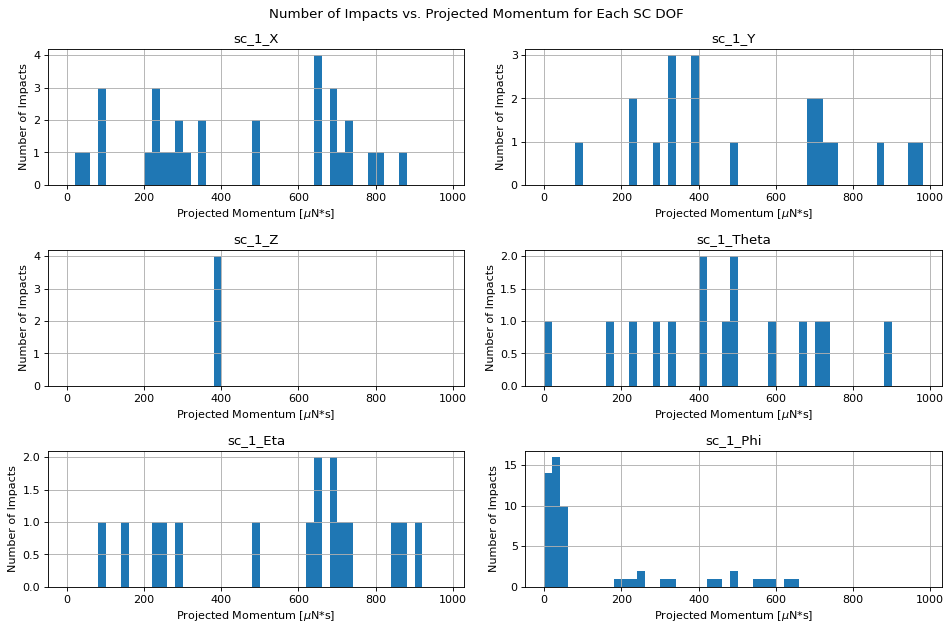

In [68]:
%matplotlib inline
N = 130
m_SC = 1415
fig, axes = plt.subplots(3, 2, figsize=(12,8),dpi=80,facecolor=(1,1,1))
plt.suptitle(f'Number of Impacts vs. Projected Momentum for Each SC DOF');
plt.tight_layout()
for i, param in enumerate(params):
    momenta = []
    max_amplitudes = []
    for impact_num in range(N): 
        with h5py.File(f"inputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5","r") as f:
            momentum = np.abs(f[param][:][np.argmax(np.abs(f[param][:]))]) * m_SC * 1e6 # conversion to micronewtons
        with h5py.File(f"outputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5","r") as f:
            max_amplitude = f[param][:][np.argmax(np.abs(f[param][:]))]
        momenta.append(momentum)
        max_amplitudes.append(max_amplitude)
        # Create axis object for each parameter 
        ax = plt.subplot(int(len(params)/2),2,i+1)
    row = i // 2  # Determine the row for the subplot
    col = i % 2   # Determine the column for the subplot
    ax = axes[row, col]     

    ax.hist(momenta, bins=np.arange(1, 1000, 20))
    # ax.set_xscale('log')
    
    # if i == 0 or i == 1 or i == 2:
    #     ax.set_xlabel('Translational offset [m]')
    # else:
    #     ax.set_xlabel('Angular offset [rad*m]')

    ax.set_xlabel(rf'Projected Momentum [$\mu$N*s]')
    ax.set_ylabel(rf'Number of Impacts') # [$\Delta$m]
    ax.set_title(f'{param}')
    ax.grid()

    
plt.tight_layout()
plt.show()
#plt.savefig('meteoroid_impact_max_displacement_vs_mom_loglog.png', dpi=80)

In [16]:
for impact_num in range(N):
    data = Data.from_lisanode(f"outputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5")
    X2   = pytdi.michelson.X2.build(**data.args)(data.measurements)
    Y2   = pytdi.michelson.Y2.build(**data.args)(data.measurements)
    Z2   = pytdi.michelson.Z2.build(**data.args)(data.measurements)
    with h5py.File(f"outputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5", "r+") as lisa:
        lisa.create_dataset("X", data=X2)
        lisa.create_dataset("Y", data=Y2)
        lisa.create_dataset("Z", data=Z2)

You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are using a LISANode file in a development version
You are us

ValueError: `data` and `shift` must be of the same size (got 2155, 2156)

In [54]:
sp = scipy.signal
injection_axes = ['sc_1_X', 'sc_1_Y','sc_1_Z', 'sc_1_Phi','sc_1_Theta', 'sc_1_Eta']
output_TDI_params = ['X','Y','Z']

impact_number = 1
cf = 1
fs = 16
fs_TDI = 4
order = 2
NFFT = 500
cut = 1000
end = int(size/4 - cut)

# Initializing all the arrays
lisa_output         = np.zeros([N, len(output_TDI_params), int(size/2)])
lisa_output_d       = np.zeros([N, len(output_TDI_params), int(size/8)])
lisa_output_TDI     = np.zeros([N, len(output_TDI_params), int(size/4)]) 
lisa_output_TDI_PSD = np.zeros([N, len(output_TDI_params), int(NFFT/2+1)])

b, a  = sp.iirfilter(order, Wn=cf, fs=fs, btype='low',ftype='butter')
d, c  = sp.iirfilter(order, Wn=cf, fs=fs_TDI, btype='low',ftype='butter')

# for j, param in enumerate(params):
#     with h5py.File(f"outputGlitch-{str(t_dur)}_meteoroid_impact_{impact_number}.h5","r") as f:
#         for i, output_param in enumerate(output_params):

#             lisa_output[i, j, :]   = f[param][:int(size/2)]
#             lisa_output_d[i, j, :] =  sp.decimate(sp.filtfilt(b, a, lisa_output[i, j, :]), 4)

for impact_num in range(129):
    for i, TDIparam in enumerate(output_TDI_params):
        with h5py.File(f"outputGlitch_duration-{str(int(t_dur))}s_impact-{impact_num+1}.h5","r") as f:
        
            lisa_output_TDI[impact_num, i, :] = f[TDIparam][:]

            lisa_output_TDI[impact_num, i, :] = sp.filtfilt(d, c, lisa_output_TDI[impact_num, i, :])

            f, lisa_output_TDI_PSD[impact_num, i, :] = sp.welch(lisa_output_TDI[impact_num, i, :], fs=fs_TDI, window='hanning', nperseg=NFFT, noverlap=NFFT//2)

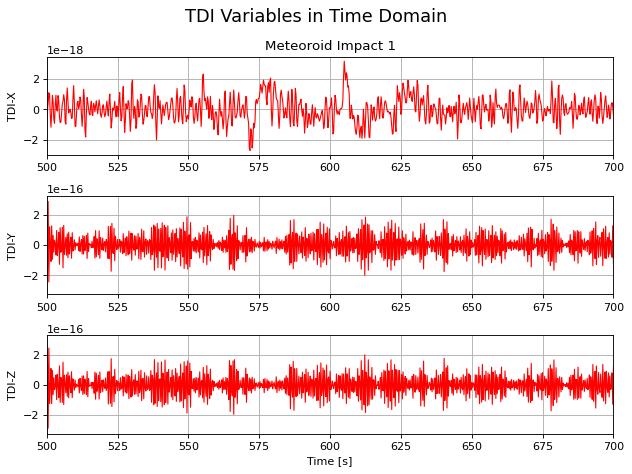

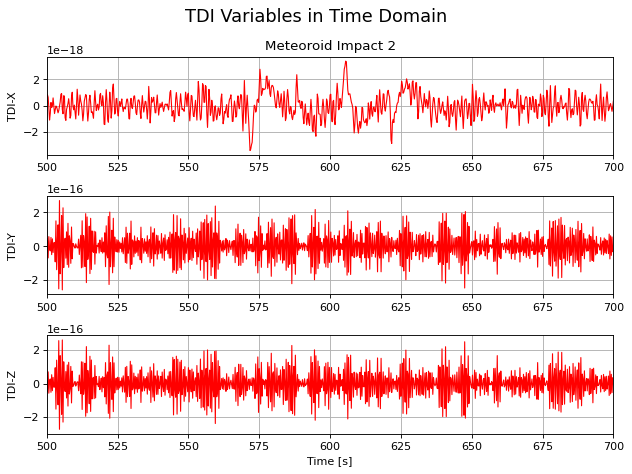

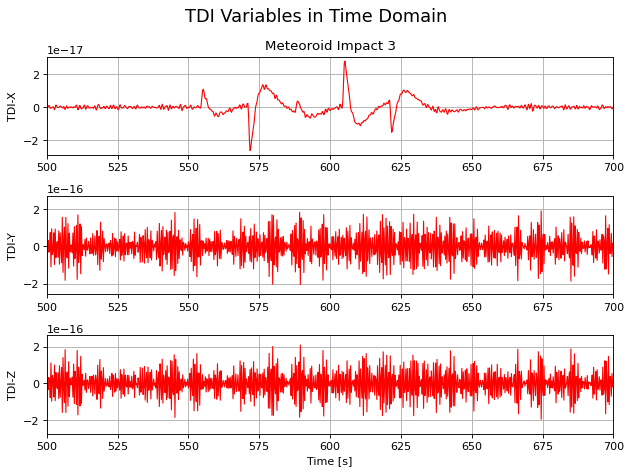

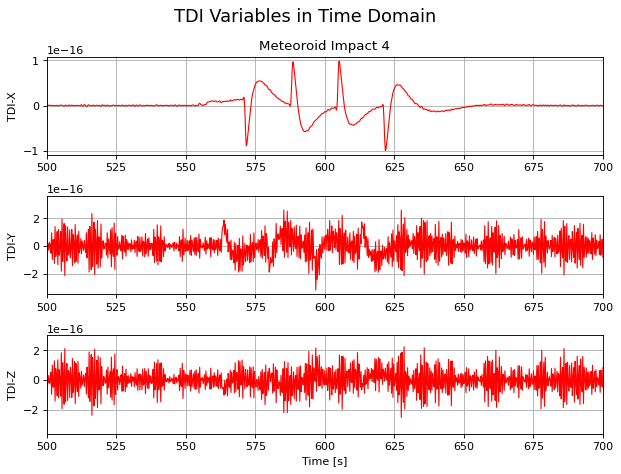

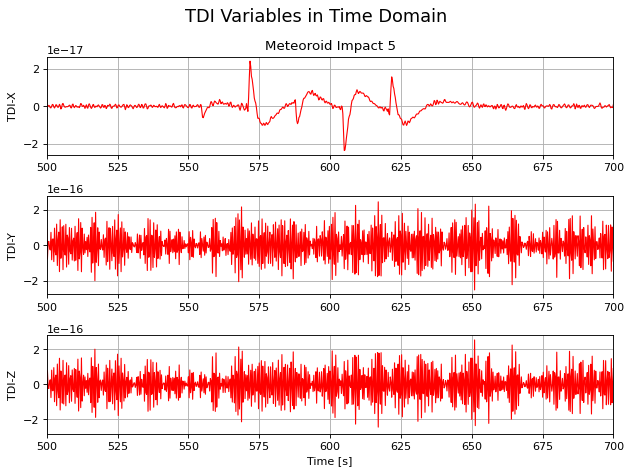

In [55]:
colors = ['black', 'red']
output_TDI_params = ['X', 'Y', 'Z']
laserfreq = 2.816E14
t = np.arange(0, sim_tdur, 4/Fs)
averaged_data = np.mean(lisa_output_TDI, axis=0)
for impact_num in range(5):
    fig, axes = plt.subplots(len(output_TDI_params), figsize=(8, 6), dpi=80, facecolor=(1, 1, 1))
    plt.tight_layout()
    fig.suptitle('TDI Variables in Time Domain', fontsize=16)

    for i, param_i in enumerate(output_TDI_params):
        ax = axes[i]  # Get the current subplot
        data = lisa_output_TDI[impact_num ,i, cut:end] / laserfreq
        ax.plot(t[cut:end], data, color='red', ls="-", label=f'TDI response', linewidth=1)
        # ax.plot(t[cut:end], averaged_data[i, cut:end]/laserfreq, color='blue', ls="-", label=f'Averaged TDI response', linewidth=1)

        if i == 0:
            ax.set_title(f'Meteoroid Impact {impact_num+1}')
        elif i == 2:
            ax.set_xlabel('Time [s]')

        ax.grid()
        ax.set_ylabel(f'TDI-{param_i}')
        # Set x-axis and y-axis limits
        ax.set_xlim([500, 700])
        
    plt.tight_layout()
    plt.show()


### C. Generate LISA simulation

### D. Generate new LISA simulation w/ glitch injection

### E. Generate TDI combinations using PyTDI

### F. Time domain analysis

#### DFACS Response

#### TDI Response

### G. Frequency domain analysis

#### DFACS Response

#### TDI Response